# Chapter 8 - Model-agnostic versus Model-specific Explainability

[Guided Integrated Gradients (Guided IG)](https://arxiv.org/abs/2106.09788) is an enhanced feature attribution method based on Integrated Gradients (IG) for deep learning models. Guided IG minimizes irrelevant attributions by introducing an adaptive path method to calculate an alternate integration path than IG. 


This notebook provides a walkthrough of Guided Integrated Gradients. You can experiment with this example on [Amazon SageMaker Studio Lab](https://aws.amazon.com/sagemaker/studio-lab/), a free ML development environment that provides up to 12 hours of CPU or 4 hours of GPU per user session and 15 GiB storage at no cost. Alternatively, you can try this on your preferred Integrated Development Environment (IDE).

## Setup
Install and Load Libraries

In [2]:
# Install essential libraries

import sys
!{sys.executable} -m pip install -r requirements.txt

In [3]:
# Load essential libraries

import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
import saliency.tf1 as saliency
import os

from platform import python_version
import warnings

warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')

%matplotlib inline

TensorFlow version: 2.11.0
Python version: 3.9.10


## Prepare for Training

Load a sample image and pre-trained Inception-v3 model for image classification.

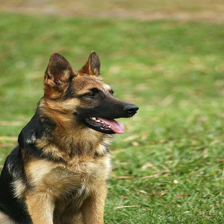

In [4]:
# Load and resize an image

IMAGE_SHAPE = (224, 224)

im = Image.open("gsdog.jpeg").resize(IMAGE_SHAPE)
im

In [5]:
# Download a pre-trained model for image classification

classifier_model = "https://tfhub.dev/google/imagenet/inception_v3/classification/3"

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
# Convert an image to NumPy array

im = np.array(im)/255.0
im.shape

(224, 224, 3)

## Make Predictions

Obtain predictions with the pre-trained model.

In [7]:
# Add a dimension to the NumPy array with np.newaxis

result = classifier.predict(im[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 743ms/step


(1, 1001)

In [8]:
# Identify the top class ID

predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=236>

In [9]:
# Decode the prediction

labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [10]:
# Read the ImageNetLabels file

imagelist = []

with open(labels_path, "r") as file:
    for line in file:
        line = line.strip()  
        line = line.strip('"')  
        if line:  
            imagelist.append(line) 
            
# Preview image classes
imagelist[:10]

['background',
 'tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen']

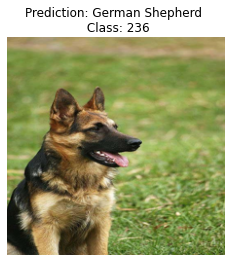

In [11]:
# View the predicted class

plt.imshow(im)
plt.axis('off')
predicted_class_name = imagelist[predicted_class]
predicted_class_index = imagelist.index(predicted_class_name)

_ = plt.title(f'Prediction: {predicted_class_name.title()} \n Class: {str(predicted_class_index)}')

plt.savefig('guidedIG_gs.png', bbox_inches='tight')

## Compare IG versus Guided IG

Create and compare saliency maps for Integrated Gradients(IG) and Guided Integrated Gradients(Guided IG).

In [12]:
# Define a graph and session for computation

graph = tf.Graph()
sess = tf.Session(graph=graph)
with graph.as_default():
  hub.Module(classifier_model)
  sess.run(tf.global_variables_initializer())
  sess.run(tf.tables_initializer())

with graph.as_default():
  images = graph.get_tensor_by_name('module/hub_input/images:0')
  logits = graph.get_tensor_by_name('module/InceptionV3/Logits/SpatialSqueeze:0')
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[:,neuron_selector]
  prediction = tf.argmax(logits, 1)

In [13]:
# Create saliency object

ig = saliency.IntegratedGradients(graph, sess, y, images)
guided_ig = saliency.GuidedIG(graph, sess, y, images)

In [14]:
# Baseline for Integrated Gradient is a black image

baseline = np.zeros(im.shape)

In [15]:
# Compute attribution mask for IG and Guided IG

ig_mask_3d = ig.GetMask(
  im, feed_dict = {neuron_selector: predicted_class_index}, x_steps=25, x_baseline=baseline, batch_size=20)
guided_ig_mask_3d = guided_ig.GetMask(
  im, feed_dict = {neuron_selector: predicted_class_index}, x_steps=25, x_baseline=baseline, max_dist=0.2, fraction=0.5)

In [16]:
# Convert 3D tensors to 2D grayscale

ig_grayscale = saliency.VisualizeImageGrayscale(ig_mask_3d)
guided_ig_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

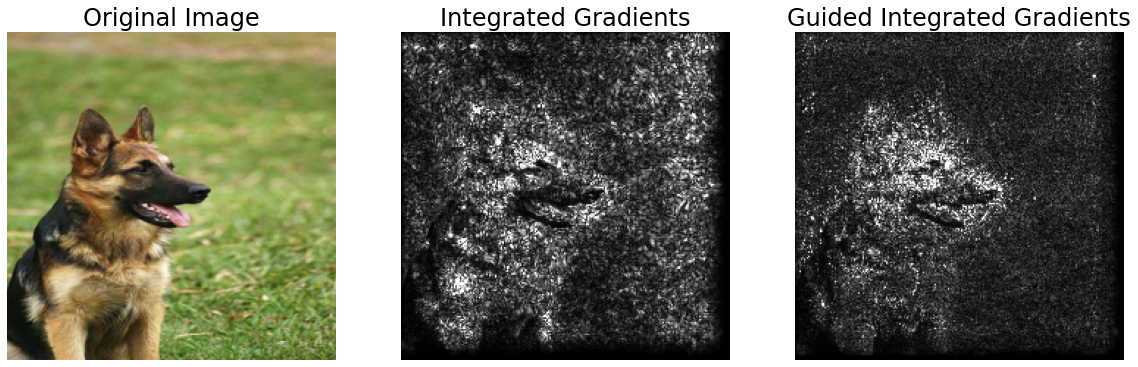

In [17]:
# Visualize saliency maps

fig = plt.figure(figsize=(20, 20))

rows = 1
columns = 3
  
fig.add_subplot(rows, columns, 1)
  
# show original
plt.imshow(im)
plt.axis('off')
plt.title("Original Image", fontsize=24)

fig.add_subplot(rows, columns, 2)
  
# show integrated gradients
plt.imshow(ig_grayscale, cmap="gray")
plt.axis('off')
plt.title("Integrated Gradients", fontsize=24)

fig.add_subplot(rows, columns, 3)
  
# show guided integrated gradients
plt.imshow(guided_ig_grayscale, cmap="gray")
plt.axis('off')
plt.title("Guided Integrated Gradients", fontsize=24)

plt.savefig('guidedIG_vs_IG.png', bbox_inches='tight')

Traditionally, backpropagation methods evaluate gradients corresponding to the input image to identify pixel attribution and produce a saliency map using weighted gradients in a neural network. The path in IG starts with a black baseline and ends at the input image by following a fixed direction where all pixels increment at the same rate, hence capturing irrelevant pixels along the way. Although IG detected most attributions, Guided IG demonstrated less noise with better visual saliency. This concludes the walkthrough for Guided IG.